# **Прогноз среднесуточной цены продажи электроэнергии**

**Описание:**


Необходимо сделать прогноз среднесуточных цен на электроэнергию по ЦЗ «Европа» на месяц вперед (30 суток).

**Задача:**

1. Загрузить и обработать данные.
2. Выполнить прогноз среднесуточной цены продажи электроэнергии по ЦЗ «Европа» на 1 месяц (горизонт прогноза – 30 суток).
3. Отобразить на графике обучающую выборку, валидационную и прогноз (выделить разным цветом).

## **Part 1. Data Pre-processing**

import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from fbprophet import Prophet
from neuralprophet import NeuralProphet
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

sns.set() 

Data

In [ ]:
# Данные за 2018 год
url='https://docs.google.com/spreadsheets/d/1KYte175JPpB4TIzkD8mAm1u2UXZr3ia9/edit?usp=sharing&ouid=108645951737947982293&rtpof=true&sd=true'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_2018 = pd.read_excel(url)

# Данные за 2019 год
url='https://docs.google.com/spreadsheets/d/1GezXvNlJA0axMWCF63mrUSUEQ8nvEAvd/edit?usp=sharing&ouid=108645951737947982293&rtpof=true&sd=true'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_2019 = pd.read_excel(url)

# Данные за 2020 год
url='https://docs.google.com/spreadsheets/d/1zjY_TEismdxgkt1D1sl1L-bi8WYGqw9h/edit?usp=sharing&ouid=108645951737947982293&rtpof=true&sd=true'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df_2020 = pd.read_excel(url)

print('2018:', df_2018.shape)
print('2019:', df_2019.shape)
print('2020:', df_2020.shape)

2018: (131400, 18)
2019: (131400, 18)
2020: (85320, 18)


In [ ]:
# Готовая таблица с 2018 по 2020 год
df = pd.concat([df_2018, df_2019, df_2020], axis = 0).sort_values(['Дата', 'ЗСП', 'Час'])
print(df.shape)
df.head()

(348120, 18)


,Дата,ЦЗ,ЗСП,Час,"План ГЭС, МВт*ч","План АЭС, МВт*ч","План ТЭС, МВт*ч","ТЭС мин, МВт*ч","ТЭС макс, МВт*ч","Потребление, МВт*ч","Экспорт, МВт*ч","Импорт, МВт*ч","План СЭС, МВт*ч","План ВЭС, МВт*ч","План ВИЭ, МВт*ч","Ценопринимающее предложение, МВт*ч","Ценопринимание сверх минимальной мощности, МВт*ч","Цена продажи, руб./МВт*ч"
131,2018-01-01 00:00:00.000,Европа,FZSZKO28,0,659.0,1350.0,73.0,73.0,80.0,1635.964,393.033,0.0,0.0,0.0,0,82975.66,4609.029,814.82
161,2018-01-01 00:00:00.000,Европа,FZSZKO28,1,612.0,1350.0,73.0,73.0,80.0,1620.972,360.003,0.0,0.0,0.0,0,81348.94,4715.726,797.03
101,2018-01-01 00:00:00.000,Европа,FZSZKO28,2,585.0,1350.0,73.0,73.0,80.0,1609.106,345.126,0.0,0.0,0.0,0,80981.34,4648.928,778.69
116,2018-01-01 00:00:00.000,Европа,FZSZKO28,3,585.0,1350.0,73.0,73.0,80.0,1602.262,352.388,0.0,0.0,0.0,0,80639.20,4638.932,727.74
145,2018-01-01 00:00:00.000,Европа,FZSZKO28,4,575.0,1350.0,73.0,73.0,80.0,1591.005,353.845,0.0,0.0,0.0,0,80443.69,4467.929,691.07


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348120 entries, 131 to 85319
Data columns (total 18 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   Дата                                              348120 non-null  object 
 1   ЦЗ                                                348120 non-null  object 
 2   ЗСП                                               348120 non-null  object 
 3   Час                                               348120 non-null  int64  
 4   План ГЭС, МВт*ч                                   348120 non-null  float64
 5   План АЭС, МВт*ч                                   348120 non-null  float64
 6   План ТЭС, МВт*ч                                   348120 non-null  float64
 7   ТЭС мин, МВт*ч                                    348120 non-null  float64
 8   ТЭС макс, МВт*ч                                   348120 non-null  float64
 9   Пот

Cleaning and Prepping Data


In [ ]:
# Обновим колонку с датой 
df['Дата'] = pd.to_datetime(df['Дата']) + pd.to_timedelta(df['Час'], unit='h')
common_plan = df.loc[:,['План ГЭС, МВт*ч',
                        'План АЭС, МВт*ч', 
                        'План ТЭС, МВт*ч', 
                        'План СЭС, МВт*ч',
                        'План ВЭС, МВт*ч',
                        'План ВИЭ, МВт*ч']].sum(axis=1)
# 'Минимальная мощность в ЗСП (Учет общего плана и мин. возможности ТЭС'
min_power = common_plan - df['План ТЭС, МВт*ч'] + df['ТЭС мин, МВт*ч']
# 'Максимальная мощность в ЗСП (Учет общего плана и мин. возможности ТЭС'
max_power = common_plan - df['План ТЭС, МВт*ч'] + df['ТЭС макс, МВт*ч']

# # Дропним не нужные колонки
df.drop(df.iloc[:,[1, 3, 4, 5, 6, 7, 8, 12, 13, 14]], axis = 1, inplace = True)

# Добавим новые признаки
df.insert(2, 'Общий план, МВт*ч', common_plan)
df.insert(3, 'Мин. мощность, МВт*ч', min_power)
df.insert(4, 'Макс. мощность, МВт*ч', max_power)
df.insert(6, 'Остаток мощности, МВт*ч', df['Общий план, МВт*ч'] - df['Потребление, МВт*ч'])
df.insert(9, 'Баланс продажи/покурки', df['Экспорт, МВт*ч'] - df['Импорт, МВт*ч'])

In [ ]:
# Итоговый датафрейм
df.head()

,Дата,ЗСП,"Общий план, МВт*ч","Мин. мощность, МВт*ч","Макс. мощность, МВт*ч","Потребление, МВт*ч","Остаток мощности, МВт*ч","Экспорт, МВт*ч","Импорт, МВт*ч",Баланс продажи/покурки,"Ценопринимающее предложение, МВт*ч","Ценопринимание сверх минимальной мощности, МВт*ч","Цена продажи, руб./МВт*ч"
131,2018-01-01 00:00:00,FZSZKO28,2082.0,2082.0,2089.0,1635.964,446.036,393.033,0.0,393.033,82975.66,4609.029,814.82
161,2018-01-01 01:00:00,FZSZKO28,2035.0,2035.0,2042.0,1620.972,414.028,360.003,0.0,360.003,81348.94,4715.726,797.03
101,2018-01-01 02:00:00,FZSZKO28,2008.0,2008.0,2015.0,1609.106,398.894,345.126,0.0,345.126,80981.34,4648.928,778.69
116,2018-01-01 03:00:00,FZSZKO28,2008.0,2008.0,2015.0,1602.262,405.738,352.388,0.0,352.388,80639.20,4638.932,727.74
145,2018-01-01 04:00:00,FZSZKO28,1998.0,1998.0,2005.0,1591.005,406.995,353.845,0.0,353.845,80443.69,4467.929,691.07


In [ ]:
df.corr()

,"Общий план, МВт*ч","Мин. мощность, МВт*ч","Макс. мощность, МВт*ч","Потребление, МВт*ч","Остаток мощности, МВт*ч","Экспорт, МВт*ч","Импорт, МВт*ч",Баланс продажи/покурки,"Ценопринимающее предложение, МВт*ч","Ценопринимание сверх минимальной мощности, МВт*ч","Цена продажи, руб./МВт*ч"
"Общий план, МВт*ч",1.000000,0.986591,0.995980,0.954597,0.354132,0.781146,0.472335,0.277395,0.124545,0.072806,-0.054682
"Мин. мощность, МВт*ч",0.986591,1.000000,0.986161,0.931204,0.382635,0.836042,0.495864,0.306125,0.114026,0.038323,-0.061000
"Макс. мощность, МВт*ч",0.995980,0.986161,1.000000,0.960055,0.323526,0.767602,0.491405,0.246537,0.099843,0.036643,-0.078424
"Потребление, МВт*ч",0.954597,0.931204,0.960055,1.000000,0.059457,0.651725,0.658476,-0.021221,0.128989,0.076730,-0.001253
"Остаток мощности, МВт*ч",0.354132,0.382635,0.323526,0.059457,1.000000,0.571578,-0.484403,0.996137,0.012403,0.003087,-0.179296
"Экспорт, МВт*ч",0.781146,0.836042,0.767602,0.651725,0.571578,1.000000,0.439439,0.513006,0.053241,0.049915,-0.004526
"Импорт, МВт*ч",0.472335,0.495864,0.491405,0.658476,-0.484403,0.439439,1.000000,-0.545628,0.050279,0.056291,0.193186
Баланс продажи/покурки,0.277395,0.306125,0.246537,-0.021221,0.996137,0.513006,-0.545628,1.000000,0.001623,-0.007224,-0.188830
"Ценопринимающее предложение, МВт*ч",0.124545,0.114026,0.099843,0.128989,0.012403,0.053241,0.050279,0.001623,1.000000,0.504174,0.269834
"Ценопринимание сверх минимальной мощности, МВт*ч",0.072806,0.038323,0.036643,0.076730,0.003087,0.049915,0.056291,-0.007224,0.504174,1.000000,0.536312


In [ ]:
ЗСП = df.ЗСП.unique()
ЗСП

array(['FZSZKO28  ', 'FZSZOE27  ', 'FZURKR12  ', 'FZURNT09  ',
       'FZUROE07  ', 'FZURTU08  ', 'FZVLBS15  ', 'FZVLOE13  ',
       'FZYUAS18  ', 'FZYUDA23  ', 'FZYUKU20  ', 'FZYUOE16  ',
       'FZYUVG17  ', 'FZZMSK26  ', 'FZZNOE24  '], dtype=object)

In [ ]:
# тестовая выборка с 2018-01-01 по 2020-07-25
X_train = df[df['Дата'] < '2020-07-26'].drop('Цена продажи, руб./МВт*ч', axis = 1)
y_train = df[df['Дата'] < '2020-07-26']['Цена продажи, руб./МВт*ч']
full_train = df[df['Дата'] < '2020-07-26']

# валидационная выборка с 2020-07-26 по 2020-08-24 (30 дней)
X_valid = df[(df['Дата'] >= '2020-07-26') & (df['Дата'] < '2020-08-25')].drop('Цена продажи, руб./МВт*ч', axis = 1)
y_valid = df[(df['Дата'] >= '2020-07-26') & (df['Дата'] < '2020-08-25')]['Цена продажи, руб./МВт*ч']
full_valid = df[(df['Дата'] >= '2020-07-26') & (df['Дата'] < '2020-08-25')]

# прогноз          с 2020-08-25 по 2020-09-23 (30 дней)

## **Part 2. Create a models. Training**

### Model 1. Prophet

In [ ]:
# Датафрейм для Prophet
df1 = df.copy(deep = True)
df1['ds'] = df1['Дата'].dt.date
df1 = (df1.groupby('ds').mean()
                         .rename(columns={'Цена продажи, руб./МВт*ч':'y'})
                         .reset_index())
df1['ds'] = pd.to_datetime(df1['ds'])
df1.head()

,ds,"Общий план, МВт*ч","Мин. мощность, МВт*ч","Макс. мощность, МВт*ч","Потребление, МВт*ч","Остаток мощности, МВт*ч","Экспорт, МВт*ч","Импорт, МВт*ч",Баланс продажи/покурки,"Ценопринимающее предложение, МВт*ч","Ценопринимание сверх минимальной мощности, МВт*ч",y
0,2018-01-01,5916.420897,5213.408197,6587.688592,5689.645258,226.775639,1475.733022,1427.324747,48.408275,83557.053333,5441.055375,1011.108528
1,2018-01-02,6031.489750,5181.531283,6564.666678,5785.262508,246.227242,1596.544372,1538.811164,57.733208,83175.086250,5534.033667,1151.511167
2,2018-01-03,6098.535094,5189.785136,6577.727692,5855.870194,242.664900,1584.128833,1530.422042,53.706792,83904.132917,6125.355875,1220.935000
3,2018-01-04,6197.729192,5186.734228,6601.825069,5957.162692,240.566500,1576.168247,1523.510028,52.658219,83483.755833,5750.659083,1274.934472
4,2018-01-05,6275.839336,5287.674728,6713.384931,6003.815508,272.023828,1634.332242,1554.408989,79.923253,84750.559583,5509.438667,1221.152639


In [ ]:
# тренировочная выборка с 2018-01-01 по 2020-07-25
# валидационная выборка с 2020-07-26 по 2020-08-24 (30 дней)
# прогноз               с 2020-08-25 по 2020-09-23 (30 дней)
df1_train = df1[df1['ds'] < '2020-07-26']

In [ ]:
# Обучение модели
m = Prophet(interval_width=0.95, yearly_seasonality=True, 
                                 weekly_seasonality=True, 
                                 daily_seasonality=True)
model = m.fit(df1_train)

# Прогноз
future = m.make_future_dataframe(periods=60,freq='D')
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,1036.054637,1017.010824,1301.507416,1036.054637,1036.054637,129.957377,129.957377,129.957377,106.147871,...,6.565561,6.565561,6.565561,17.243945,17.243945,17.243945,0.0,0.0,0.0,1166.012013
1,2018-01-02,1036.422370,1000.116977,1286.420680,1036.422370,1036.422370,110.602584,110.602584,110.602584,106.147871,...,-10.383669,-10.383669,-10.383669,14.838382,14.838382,14.838382,0.0,0.0,0.0,1147.024953
2,2018-01-03,1036.790103,1031.142831,1301.597611,1036.790103,1036.790103,125.663475,125.663475,125.663475,106.147871,...,6.469420,6.469420,6.469420,13.046185,13.046185,13.046185,0.0,0.0,0.0,1162.453578
3,2018-01-04,1037.157836,1029.549920,1296.017371,1037.157836,1037.157836,127.297881,127.297881,127.297881,106.147871,...,9.261667,9.261667,9.261667,11.888343,11.888343,11.888343,0.0,0.0,0.0,1164.455716
4,2018-01-05,1037.525568,1039.143656,1303.842124,1037.525568,1037.525568,133.879766,133.879766,133.879766,106.147871,...,16.361255,16.361255,16.361255,11.370640,11.370640,11.370640,0.0,0.0,0.0,1171.405335


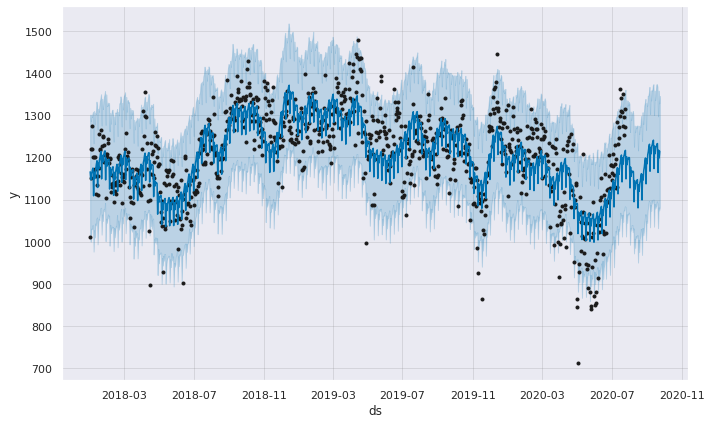

In [ ]:
# Фактические данные и прогноз модели с доверительным интервалом
plt1 = m.plot(forecast)

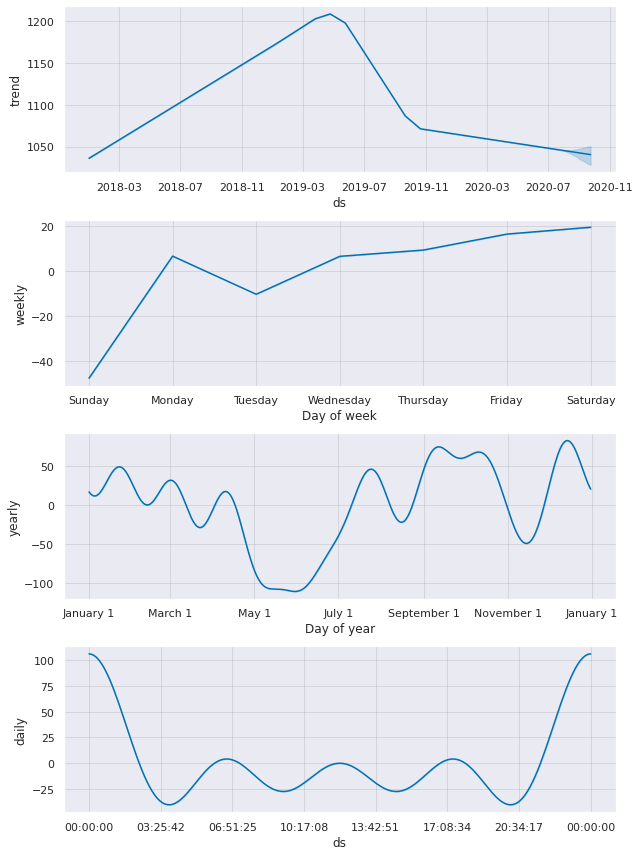

In [ ]:
# Декомпозиция
plt2 = m.plot_components(forecast)

In [ ]:
# Данные для визуализации

# Актуальные данные с 2020-03-26 по 2020-08-24
true = df1[['ds','y']].rename(columns={'ds':'Дата', 'y':'Цена'})[df1['ds']>= '2020-03-24']

# результаты прогнозной модели: с 2020-07-26 по 2020-09-23 (60 дней)
predict_P = (forecast[forecast['ds']>= '2020-03-24'][['ds', 'yhat']]
                    .rename(columns= {'ds':'Дата', 'yhat':'Цена'}))

# Доверительный интервал прогнрзной модели
conf_upper = (forecast[(forecast['ds'] >= '2020-07-26') & 
                       (forecast['ds'] < '2020-08-25')].set_index('ds')['yhat_upper'])
conf_lower = (forecast[(forecast['ds'] >= '2020-07-26') & 
                       (forecast['ds'] < '2020-08-25')].set_index('ds')['yhat_lower'])

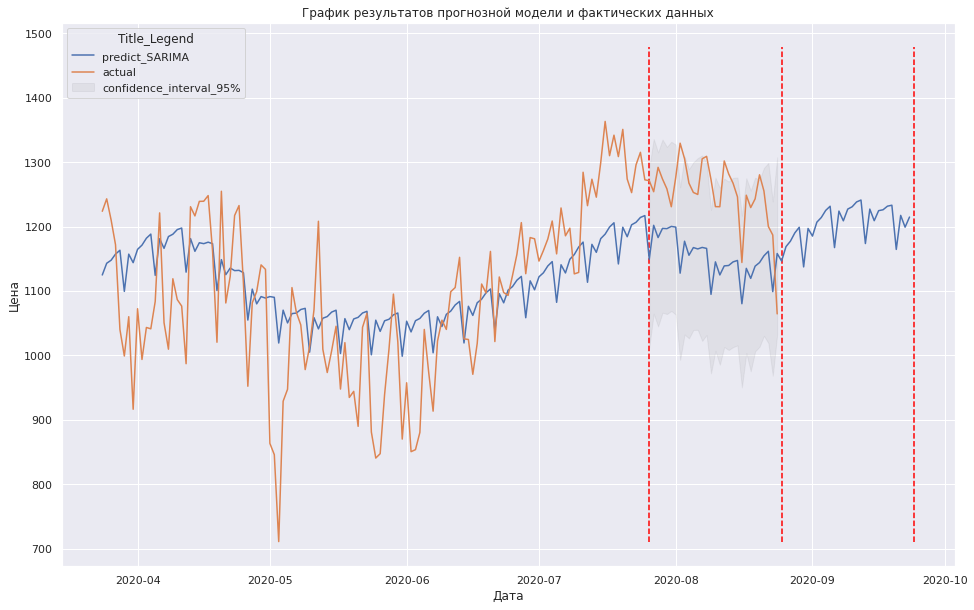

In [ ]:
# тренировочная  выборка с 2020-03-24 по 2020-07-26 (120 дней)
# валидационная  выборка с 2020-07-26 по 2020-08-24 (30 дней)
# прогноз                с 2020-08-25 по 2020-09-23 (30 дней)

# Отрисовка графика
plt.figure(figsize = (16,10))
sns.lineplot(data = predict_P, x= 'Дата', y = 'Цена', legend = True)
sns.lineplot(data = true, x= 'Дата', y = 'Цена') 
plt.fill_between(conf_upper.index, 
                 conf_upper, 
                 conf_lower, 
                 color='k', alpha=.05)  
plt.title('График результатов прогнозной модели и фактических данных')
plt.vlines(x = datetime(2020, 7, 26), ymin = df1['y'].min(), 
           ymax = df1['y'].max(), linestyles='dashed', colors='red') # отсечка тренировочных и валидационных данных
plt.vlines(x = datetime(2020, 8, 25), ymin = df1['y'].min(), 
           ymax = df1['y'].max(), linestyles='dashed', colors='red'); # отсечка валидационных и прогнозных данных
plt.vlines(x = datetime(2020, 9, 24), ymin = df1['y'].min(), 
           ymax = df1['y'].max(), linestyles='dashed', colors='red'); # отсечка прогнозных данных
plt.legend(labels=['predict_SARIMA', 'actual','confidence_interval_95%'], title = "Title_Legend", loc = 'upper left')

In [ ]:
# Проверка валидационной части метриками MAE, MSE, RMSE

y_true = true[(true['Дата'] >= '2020-07-26') & (true['Дата'] < '2020-08-25')]['Цена'].reset_index()
y_pred = predict_P[(predict_P['Дата'] >= '2020-07-26') & (predict_P['Дата'] < '2020-08-25')]['Цена'].reset_index()

# Метрика MAE
print('MAE:', mean_absolute_error(y_true, y_pred))

# Метрика MSE
print('MSE:', mean_squared_error(y_true, y_pred))

# Метрика RMSE
print('RMSE:', mean_squared_error(y_true, y_pred, squared = False))

MAE: 52.74274045858986
MSE: 6292.112934496809
RMSE: 56.0897180171946


### Model 2. NeuralProphet

In [ ]:
# Датафрейм для NeuralProphet
df2 = df.copy(deep = True)
df2['ds'] = df2['Дата'].dt.date
df2 = (df2.groupby('ds').mean()
                         .rename(columns={'Цена продажи, руб./МВт*ч':'y'})
                         .reset_index())
df2['ds'] = pd.to_datetime(df2['ds'])
df2 = df2[['ds', 'y']]
df2.head()

,ds,y
0,2018-01-01,1011.108528
1,2018-01-02,1151.511167
2,2018-01-03,1220.935000
3,2018-01-04,1274.934472
4,2018-01-05,1221.152639


In [ ]:
# тренировочная выборка с 2018-01-01 по 2020-07-25
# валидационная выборка с 2020-07-26 по 2020-08-24 (30 дней)
# прогноз               с 2020-08-25 по 2020-09-23 (30 дней)
df2_train = df2[df2['ds'] < '2020-07-26']

In [ ]:
# Обучение модели
m = NeuralProphet(yearly_seasonality=True, 
                  weekly_seasonality=True, 
                  daily_seasonality=True)
model = m.fit(df2_train)

# Прогнозирование
future = m.make_future_dataframe(df2_train, periods=60, n_historic_predictions = True)
forecast = m.predict(future)
forecast.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.893% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.893% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO:NP.df_utils:Dataframe freq automatically defined as D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO:NP.config:Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 198
INFO:NP.config:Auto-set epochs to 198


  0%|          | 0/125 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.88E-01, min: 2.35E-02
INFO:NP.utils_torch:lr-range-test results: steep: 2.88E-01, min: 2.35E-02


  0%|          | 0/125 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.88E-01, min: 1.99E-02
INFO:NP.utils_torch:lr-range-test results: steep: 2.88E-01, min: 1.99E-02
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 2.03E-01
INFO:NP.forecaster:lr-range-test selected learning rate: 2.03E-01
Epoch[198/198]: 100%|██████████| 198/198 [00:50<00:00,  3.88it/s, SmoothL1Loss=0.00517, MAE=50.9, RMSE=64.2, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.893% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.893% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO:NP.df_utils:Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.9% of the data.
INFO:NP.df_utils:Major frequency D corresponds to 99.9% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to ma

,ds,y,yhat1,residual1,trend,season_yearly,season_weekly,season_daily
0,2018-01-01,1011.108528,1196.100098,184.991570,884.528931,106.331474,8.164750,197.074936
1,2018-01-02,1151.511167,1176.915161,25.403994,886.047119,103.952911,-10.159822,197.074936
2,2018-01-03,1220.935000,1191.627930,-29.307070,887.565369,101.523735,5.463903,197.074936
3,2018-01-04,1274.934472,1194.873535,-80.060937,889.083618,99.064957,9.649986,197.074936
4,2018-01-05,1221.152639,1201.840332,-19.312307,890.601807,96.596901,17.566599,197.074936


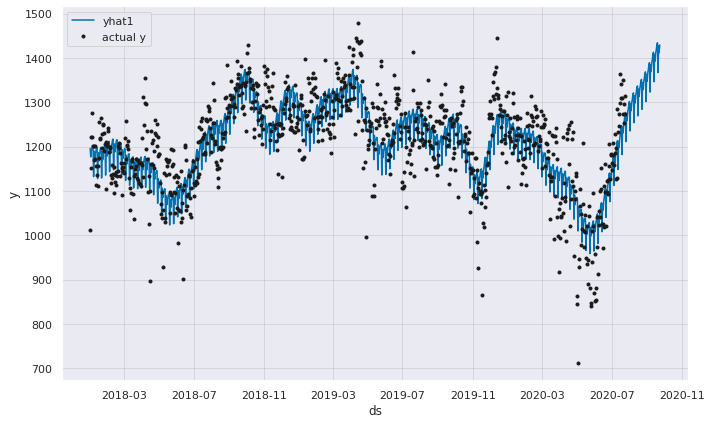

In [ ]:
# Фактические данные и прогноз модели
plt1 = m.plot(forecast)

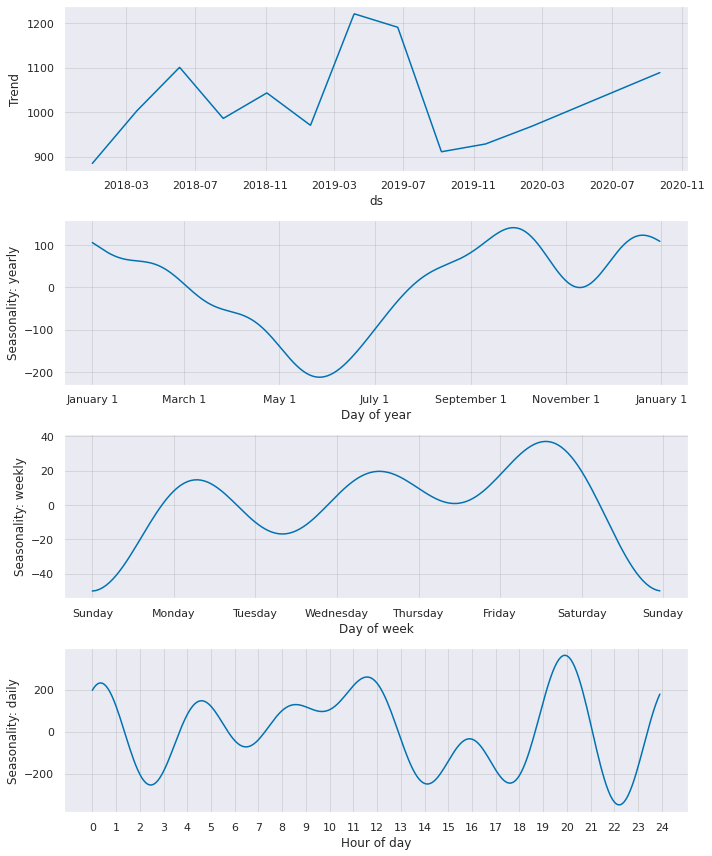

In [ ]:
# Декомпозиция
plt2 = m.plot_components(forecast)

In [ ]:
# Реальные результаты с 2020-03-26 по 2020-08-24
true = df2[['ds','y']].rename(columns={'ds':'Дата', 'y':'Цена'})[df2['ds']>= '2020-03-24']

# результаты прогнозной модели: с 2020-07-26 по 2020-09-23 (60 дней)
predict_NP = (forecast[forecast['ds']>= '2020-03-24'][['ds', 'yhat1']]
                    .rename(columns= {'ds':'Дата', 'yhat1':'Цена'}))

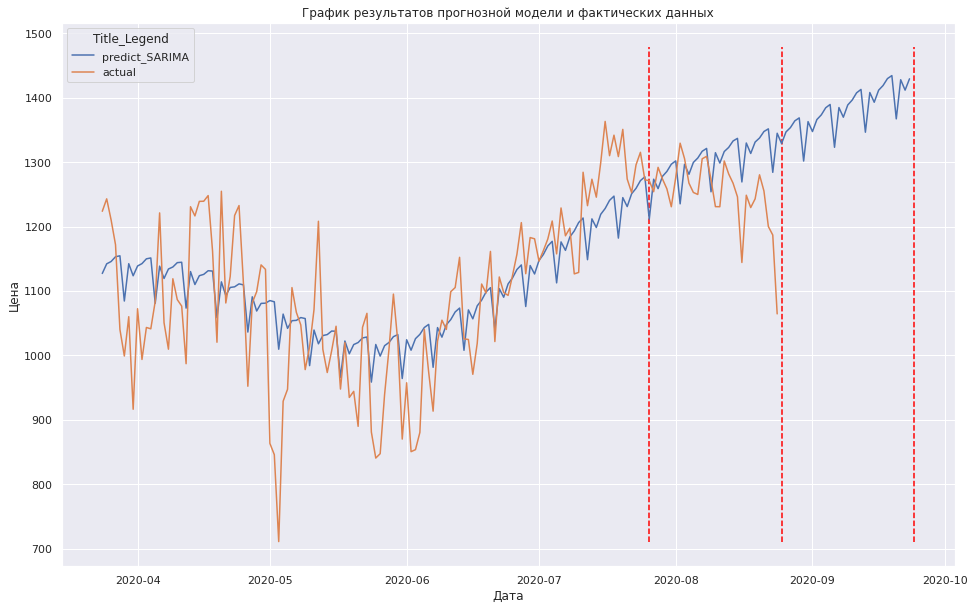

In [ ]:
# тренировочная  выборка с 2020-03-24 по 2020-07-26 (120 дней)
# валидационная  выборка  с 2020-07-26 по 2020-08-24 (30 дней)
# прогноз                 с 2020-08-25 по 2020-09-23 (30 дней)

# Отрисовка графика
plt.figure(figsize = (16,10))
sns.lineplot(data = predict_NP, x= 'Дата', y = 'Цена')
sns.lineplot(data = true, x= 'Дата', y = 'Цена') 
plt.title('График результатов прогнозной модели и фактических данных')
plt.vlines(x = datetime(2020, 7, 26), ymin = df2['y'].min(), 
           ymax = df2['y'].max(), linestyles='dashed', colors='red') # отсечка тестовых и валидационных данных
plt.vlines(x = datetime(2020, 8, 25), ymin = df2['y'].min(), 
           ymax = df2['y'].max(), linestyles='dashed', colors='red'); # отсечка валидационных и прогнозных данных
plt.vlines(x = datetime(2020, 9, 24), ymin = df2['y'].min(), 
           ymax = df2['y'].max(), linestyles='dashed', colors='red'); # отсечка прогнозных данных
plt.legend(labels=['predict_SARIMA', 'actual'], title = "Title_Legend", loc = 'upper left')

In [ ]:
# Проверка валидационной части метриками MAE, MSE, RMSE

y_true = true[(true['Дата'] >= '2020-07-26') & 
              (true['Дата'] < '2020-08-25')]['Цена'].reset_index()
y_pred = predict_NP[(predict_NP['Дата'] >= '2020-07-26') & 
                    (predict_NP['Дата'] < '2020-08-25')]['Цена'].reset_index()

# Метрика MAE
print('MAE:', mean_absolute_error(y_true, y_pred))

# Метрика MSE
print('MSE:', mean_squared_error(y_true, y_pred))

# Метрика RMSE
print('RMSE:', mean_squared_error(y_true, y_pred, squared = False))

MAE: 31.963314278067138
MSE: 3527.901412030451
RMSE: 41.99941316274818


### Model 3. SARIMA  (Cезонная авторегрессия скользящего среднего)

In [ ]:
# Датафрейм для SARIMA
df3 = df.copy(deep = True)
df3['ds'] = df3['Дата'].dt.date
df3 = (df3.groupby('ds').mean()
                         .rename(columns={'Цена продажи, руб./МВт*ч':'y'})
                         .reset_index())
df3['ds'] = pd.to_datetime(df3['ds'])
df3 = df3[['ds', 'y']].set_index('ds')
df3.head()

,y
ds,
2018-01-01,1011.108528
2018-01-02,1151.511167
2018-01-03,1220.935000
2018-01-04,1274.934472
2018-01-05,1221.152639


In [ ]:
df['Дата'].max()

Timestamp('2020-08-24 23:00:00')

In [ ]:
pd.date_range(start='26/7/2020', periods=30)

DatetimeIndex(['2020-07-26', '2020-07-27', '2020-07-28', '2020-07-29',
               '2020-07-30', '2020-07-31', '2020-08-01', '2020-08-02',
               '2020-08-03', '2020-08-04', '2020-08-05', '2020-08-06',
               '2020-08-07', '2020-08-08', '2020-08-09', '2020-08-10',
               '2020-08-11', '2020-08-12', '2020-08-13', '2020-08-14',
               '2020-08-15', '2020-08-16', '2020-08-17', '2020-08-18',
               '2020-08-19', '2020-08-20', '2020-08-21', '2020-08-22',
               '2020-08-23', '2020-08-24'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
# тренировочная выборка с 2018-01-01 по 2020-07-25
# валидационная выборка с 2020-07-26 по 2020-08-24 (30 дней)
# прогноз               с 2020-08-25 по 2020-09-23 (30 дней)

df3_train = df3[df3.index < '2020-07-26']
df3_valid_pred = pd.DataFrame(index = pd.date_range(start='26/7/2020', periods=60))

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,

  FutureWarning,



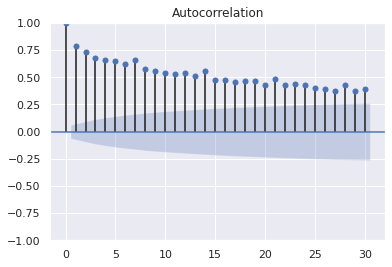

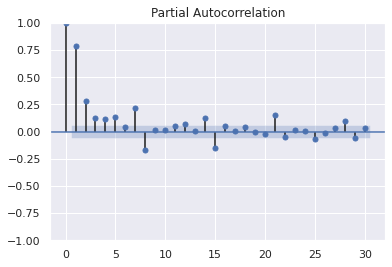

In [ ]:
# Автокорреляции
plot_acf(df3.y)
plot_pacf(df3.y)
plt.show()

In [ ]:
# # Поиск параметров и обучение модели
model = pm.auto_arima(df3_train, 
                      start_p=1,
                      start_q=1,
                      start_Q=1,
                      m=12,
                      D=1,
                      seasonal=True, 
                      trace=True,
                      error_action='ignore',
                      suppress_warnings = True, 
                      stepwise=True)
# Прогнозирование
n_periods = 60
fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
predict_index = pd.date_range(start='26/7/2020', periods=n_periods)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=4.83 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=11170.505, Time=0.09 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=10581.734, Time=2.36 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=10671.384, Time=5.69 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=11168.752, Time=0.15 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=10783.084, Time=1.22 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=10537.969, Time=16.23 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=22.76 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=10.50 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=11003.863, Time=11.07 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=10479.291, Time=14.04 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=10550.324, Time=4.77 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=21.24 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=4.21 sec
 ARIMA(3,0,0)(2,1,0)[12] inte

In [ ]:
# Данные для визуализации
lower_series = pd.Series(confint[:, 0], index=predict_index)
upper_series = pd.Series(confint[:, 1], index=predict_index)

# Реальные результаты с 2020-03-24 по 2020-08-24
true = (df3[df3.index >= '2020-03-24'].rename_axis('Дата')
                                      .rename(columns = {'y':'Цена'}))

# результаты прогнозной модели: с 2020-07-26 по 2020-09-23 (60 дней)
predict_SARIMA = (pd.DataFrame(data = {'Цена': fitted}, index=predict_index)
                                                       .rename_axis('Дата'))

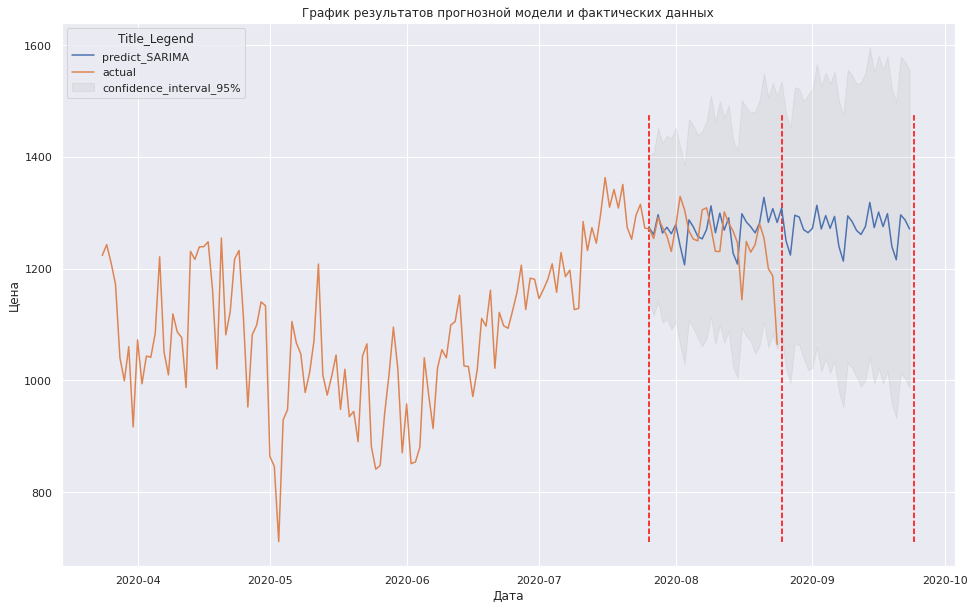

In [ ]:
# тренировочная  выборка с 2020-03-24 по 2020-07-26 (120 дней)
# валидационная  выборка  с 2020-07-26 по 2020-08-24 (30 дней)
# прогноз                 с 2020-08-25 по 2020-09-23 (30 дней)

# Отрисовка графика
plt.figure(figsize = (16,10))
sns.lineplot(data = predict_SARIMA, x= 'Дата', y = 'Цена')
sns.lineplot(data = true, x= 'Дата', y = 'Цена')
plt.fill_between(predict_index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.05, label='Area')
plt.title('График результатов прогнозной модели и фактических данных')
plt.vlines(x = datetime(2020, 7, 26), ymin = df3['y'].min(), 
           ymax = df3['y'].max(), linestyles='dashed', colors='red') # отсечка тестовых и валидационных данных
plt.vlines(x = datetime(2020, 8, 25), ymin = df3['y'].min(), 
           ymax = df3['y'].max(), linestyles='dashed', colors='red'); # отсечка валидационных и прогнозных данных
plt.vlines(x = datetime(2020, 9, 24), ymin = df3['y'].min(), 
           ymax = df3['y'].max(), linestyles='dashed', colors='red'); # отсечка прогнозных данных
plt.legend(labels=['predict_SARIMA', 'actual','confidence_interval_95%'], title = "Title_Legend", loc = 'upper left')

In [ ]:
# Проверка валидационной части метриками MAE, MSE, RMSE

y_true = true[(true.index >= '2020-07-26') & 
              (true.index < '2020-08-25')]['Цена']
y_pred = predict_SARIMA[(predict_SARIMA.index >= '2020-07-26') & 
                    (predict_SARIMA.index < '2020-08-25')]['Цена']

# Метрика MAE
print('MAE:', mean_absolute_error(y_true, y_pred))

# Метрика MSE
print('MSE:', mean_squared_error(y_true, y_pred))

# Метрика RMSE
print('RMSE:', mean_squared_error(y_true, y_pred, squared = False))

MAE: 47.08927798145867
MSE: 4577.478681312841
RMSE: 67.65706675073079


## **Part 3. Final. BEGGING**

In [ ]:
# Прогнозы 3х моделей
result_Prophet = predict_P[predict_P['Дата'] >= '2020-07-26'].set_index('Дата')
result_NeuralProphet = predict_NP[predict_P['Дата'] >= '2020-07-26'].set_index('Дата')
result_SARIMA = predict_SARIMA

# Итоговый прогноз с 2020-07-26 по 2020-09-23
result_stack = pd.concat([result_Prophet, result_NeuralProphet, result_SARIMA], axis = 1)
result_final = result_stack.mean(axis=1)

# Реальные результаты с 2020-03-24 по 2020-08-24
true = (df3[df3.index >= '2020-03-24'].rename_axis('Дата')
                                      .rename(columns = {'y':'Цена'}))

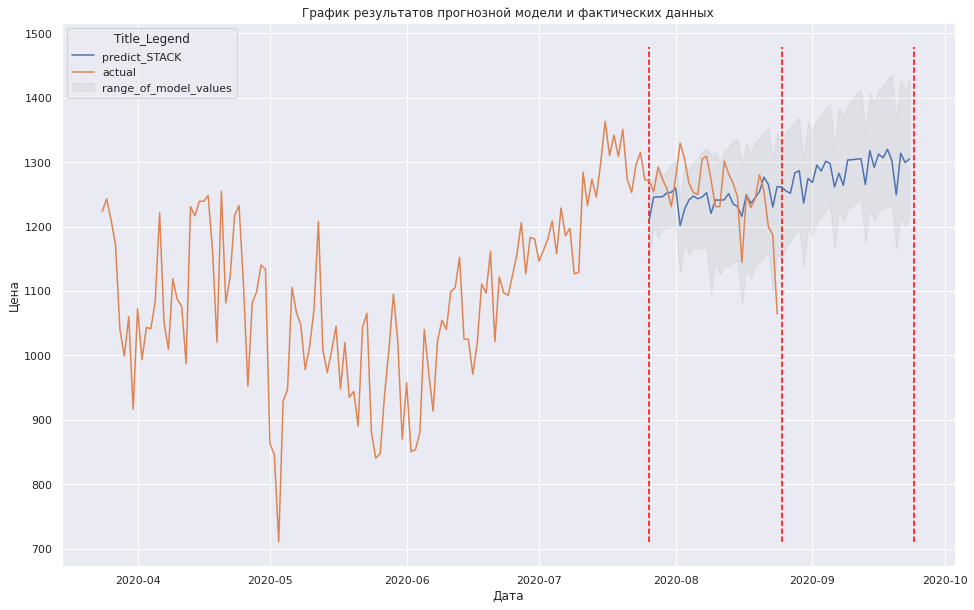

In [ ]:
# тренировочная  выборка с 2020-03-24 по 2020-07-26 (120 дней)
# валидационная  выборка  с 2020-07-26 по 2020-08-24 (30 дней)
# прогноз                 с 2020-08-25 по 2020-09-23 (30 дней)

# Визуализация
plt.figure(figsize = (16,10))
sns.lineplot(x= result_final.index, y = result_final.values)
sns.lineplot(data = true, x= 'Дата', y = 'Цена')
plt.fill_between(predict_index, 
                 result_stack.max(axis = 1), 
                 result_stack.min(axis = 1), 
                 color='k', alpha=.05)                                           # максимальные и минимальные значения моделей в итоговом стеке
plt.title('График результатов прогнозной модели и фактических данных')
plt.vlines(x = datetime(2020, 7, 26), ymin = df3['y'].min(), 
           ymax = df3['y'].max(), linestyles='dashed', colors='red')             # отсечка тестовых и валидационных данных
plt.vlines(x = datetime(2020, 8, 25), ymin = df3['y'].min(), 
           ymax = df3['y'].max(), linestyles='dashed', colors='red');            # отсечка валидационных и прогнозных данных
plt.vlines(x = datetime(2020, 9, 24), ymin = df3['y'].min(), 
           ymax = df3['y'].max(), linestyles='dashed', colors='red');            # отсечка прогнозных данных
plt.legend(labels=['predict_STACK', 'actual','range_of_model_values'], title = "Title_Legend", loc = 'upper left')

In [ ]:
# Проверка валидационной части метриками MAE, MSE, RMSE

y_pred = result_final[result_final.index < '2020-08-25']
y_true = (true[(true.index >= '2020-07-26') & 
              (true.index < '2020-08-25')]['Цена'])

# Метрика MAE
print('MAE:', mean_absolute_error(y_true, y_pred))

# Метрика MSE
print('MSE:', mean_squared_error(y_true, y_pred))

# Метрика RMSE
print('RMSE:', mean_squared_error(y_true, y_pred, squared = False))

MAE: 39.757516014258776
MSE: 3251.0791226271153
RMSE: 57.01823500098118
